# Simple PINN for an elastic plate with an elliptical hole 

## Represent geometry

We represent the geometry by a set of collocation points 

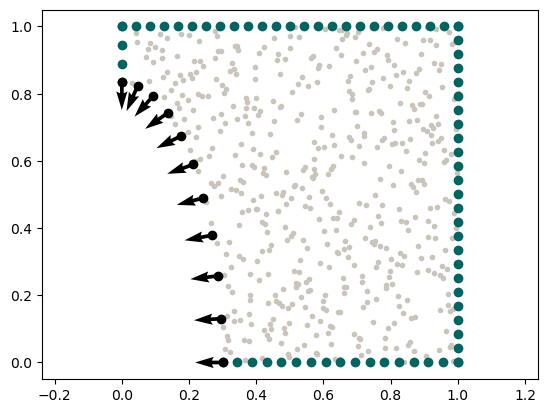

In [155]:
import torch 
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from tqdm import tqdm


from global_constants import L, R, B0, EPS0, MU, LBD, RATIO

# Elliptical axis in x direction
Rx = 0.3

# Load reference data
data_input = torch.as_tensor(np.loadtxt(f"data/inputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float32)
data_output = torch.as_tensor(np.loadtxt(f"data/outputs_Rx={Rx}.csv", delimiter=","), dtype=torch.float32)

# Create collocation points
N = 25
points = L * qmc.LatinHypercube(d=2).random(N**2)
Ry = R**2/Rx
mask = (((points[:,0] ** 2)/(Rx**2)) + ((points[:,1] ** 2)/(Ry**2))) > 1
collocation = torch.tensor(points[mask], requires_grad=True).float()

# Boundary points
x_top = torch.linspace(0, L, N, requires_grad=True)
y_top = L * torch.ones((N, 1), requires_grad=True)
top = torch.column_stack([x_top, y_top])

NN = int(N * (L-Rx)/L)
x_bottom = torch.linspace(Rx, L, NN)
y_bottom = torch.zeros((NN, 1))
bottom = torch.column_stack([x_bottom, y_bottom])

NN = int(N * (L-Ry)/L)
x_left = torch.zeros((NN, 1))
y_left = torch.linspace(Ry, L, NN)
left = torch.column_stack([x_left, y_left])

x_right = L * torch.ones((N, 1))
y_right = torch.linspace(0, L, N)
right = torch.column_stack([x_right, y_right])

phi = np.linspace(0, 0.5 * np.pi, int(N * 0.5 * np.pi * Rx / L))
x_hole = torch.tensor(Rx * np.cos(phi), requires_grad=True).float()
y_hole = torch.tensor(Ry * np.sin(phi), requires_grad=True).float()
n_hole = torch.tensor(np.stack([-Ry*np.cos(phi), -Rx*np.sin(phi)]).T).float()
n_hole = n_hole / torch.linalg.norm(n_hole,axis=1)[:,None]
hole = torch.column_stack([x_hole, y_hole])

# Visualize geometry
with torch.no_grad():
    plt.scatter(*collocation.T, marker=".", color="#C9C5BC")
    plt.scatter(*top.T, marker="o", color="#006561")
    plt.scatter(*bottom.T, marker="o", color="#006561")
    plt.scatter(*left.T, marker="o", color="#006561")
    plt.scatter(*right.T, marker="o", color="#006561")
    plt.scatter(*hole.T, marker="o", color="black")
    plt.quiver(*hole.T, n_hole[:,0], n_hole[:,1], color="black")
    plt.axis("equal")
    plt.show()


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [156]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hn = 20
        self.hidden_layer1 = torch.nn.Linear(2,hn)
        self.hidden_layer2 = torch.nn.Linear(hn,hn)
        self.hidden_layer3 = torch.nn.Linear(hn,hn)
        self.hidden_layer4 = torch.nn.Linear(hn,hn)
        self.hidden_layer5 = torch.nn.Linear(hn,hn)
        self.output_layer = torch.nn.Linear(hn,2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output
    
net = Net()

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [157]:
def sigma(x):
    dudx = torch.func.jacrev(net)(x)
    eps =  0.5 * (dudx + dudx.T)
    return 2.0 * MU * eps + LBD * torch.trace(eps) * torch.eye(2)

def pde_residual(x):
    dsdx = torch.func.jacrev(sigma)(x)
    residual_x = dsdx[0,0,0] + dsdx[0,1,1] - B0
    residual_y = dsdx[1,0,0] + dsdx[1,1,1]
    return residual_x, residual_y


## The loss function

In [158]:
W_PDE = 0.01
W_NEUMANN = 0.1
W_DATA = 1.0

mse = torch.nn.MSELoss()


def compute_loss(net, collocation):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(collocation)
    zeros = torch.zeros_like(res_x)
    pde_error = mse(res_x, zeros) + mse(res_y, zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:,0])
    left_error = mse(pred_left[:,0], bc_left) 

    # right boundary
    pred_right = net(right)
    bc_right = EPS0 * L * torch.ones_like(pred_right[:,0])
    right_error = mse(pred_right[:,0], bc_right) 

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:,1])
    bottom_error = mse(pred_bottom[:,1], bc_bottom) 

    # top boundary
    pred_top = net(top)
    bc_top = RATIO * EPS0 * L * torch.ones_like(pred_top[:,1])
    top_error = mse(pred_top[:,1], bc_top)

    # hole boundary
    stress_hole = torch.vmap(sigma)(hole)
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:,0])
    hole_error = mse(traction[:,0], zeros) + mse(traction[:,1], zeros)

    # data error 
    samples = torch.randperm(data_output.size()[0])[::100]
    stress_data = data_output[samples, 0:3]
    stress_prediction = torch.vmap(sigma)(data_input[samples, 0:2])
    data_error = mse(stress_data[:,0], stress_prediction[:,0,0]) + mse(stress_data[:,1], stress_prediction[:,1,1]) + mse(stress_data[:,2], stress_prediction[:,0,1])

    return (
        left_error
        + right_error
        + bottom_error
        + top_error
        + W_NEUMANN * hole_error
        + W_PDE * pde_error
        + W_DATA * data_error
    )


## Training 

100%|██████████| 5000/5000 [07:00<00:00, 11.90it/s]


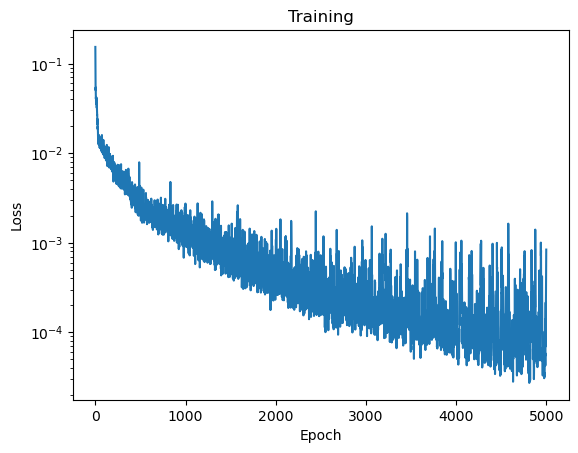

In [159]:
history = []

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

batch_size = 64

for epoch in tqdm(range(5000)):
    permutation = torch.randperm(collocation.size()[0])
    for i in range(0, collocation.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        optimizer.zero_grad()
        loss = compute_loss(net, collocation[indices])
        loss.backward(retain_graph=True)
        optimizer.step()

    with torch.autograd.no_grad():
    	history.append(float(loss.data))
    
plt.semilogy(history)
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


## Visualization of results

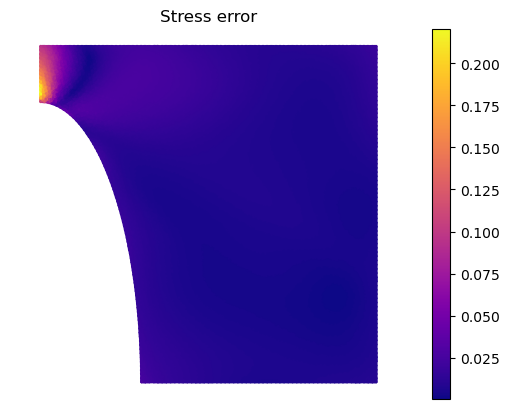

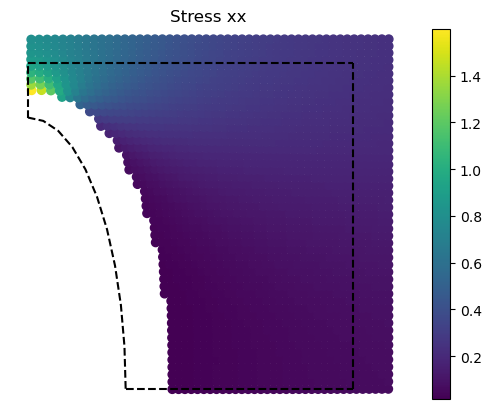

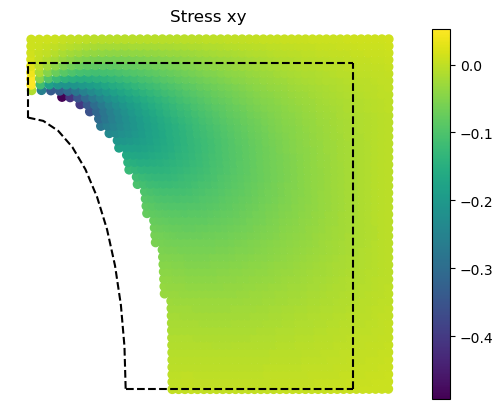

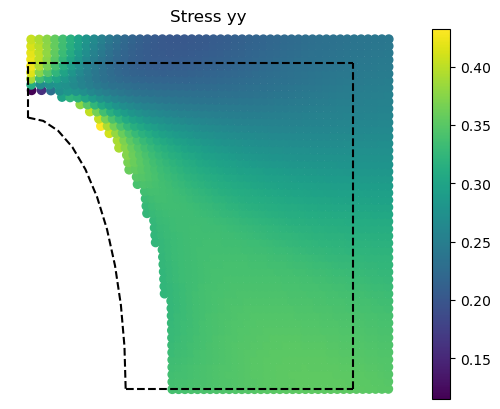

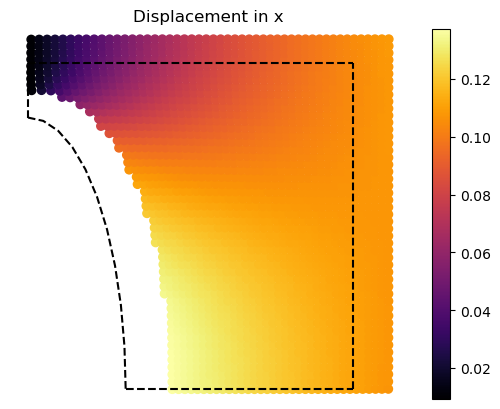

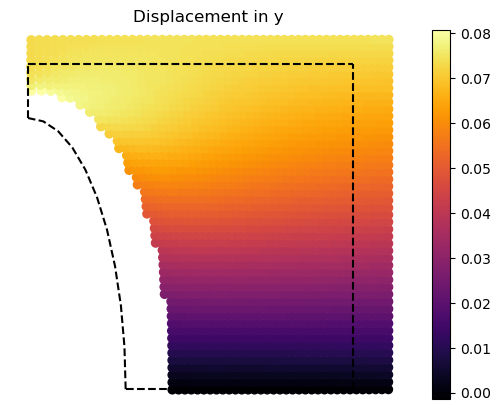

In [160]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (((val_domain[:,0] ** 2)/(Rx**2)) + ((val_domain[:,1] ** 2)/(Ry**2))) > 1
val = torch.tensor(val_domain[mask], requires_grad=True).float()

# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
stress = torch.vmap(sigma)(val)
residual_x, residual_y = torch.vmap(pde_residual)(top)


@torch.no_grad()
def make_plot(variable, title, **kwargs):
    plt.plot(*top.T, "--k")
    plt.plot(*bottom.T, "--k")
    plt.plot(*left.T, "--k")
    plt.plot(*right.T, "--k")
    plt.plot(*hole.T, "--k")
    plt.scatter(*def_val.T, c=variable, **kwargs)
    plt.axis("equal")
    plt.axis('off')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot data error
stress_data = data_output[:, 0:3]
stress_prediction = torch.vmap(sigma)(data_input[:, 0:2])
data_error = torch.sqrt((stress_data[:,0]-stress_prediction[:,0,0])**2 
                        + (stress_data[:,1]-stress_prediction[:,1,1])**2 
                        + (stress_data[:,2]-stress_prediction[:,0,1])**2)
plt.scatter(data_input[:, 0], data_input[:,1], c=data_error.detach(), s=1.0, cmap="plasma")
plt.axis("equal")
plt.axis('off')
plt.colorbar()
plt.title("Stress error")
plt.show()

make_plot(stress[:, 0, 0], "Stress xx")
make_plot(stress[:, 0, 1], "Stress xy")
make_plot(stress[:, 1, 1], "Stress yy")
make_plot(disp[:, 0], "Displacement in x", cmap="inferno")
make_plot(disp[:, 1], "Displacement in y", cmap="inferno")